In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Import necessary libraries
import sys
from pathlib import Path
# Ensure the src directory is accessible
sys.path.append('./src')

# Get data

In [2]:
import get_data 
train_all_data, test_all_data = get_data.get_cardiotoxnet_data()

train data contains 12620 compounds:
	6643 hERG blockers and 5977 non-blockers
test_0 contains 44 compounds:
	30 hERG blockers and 14 non-blockers
test_1 contains 41 compounds:
	11 hERG blockers and 30 non-blockers
test_2 contains 740 compounds:
	34 hERG blockers and 706 non-blockers


In [3]:
random_state = 42
test_percent = 0.2
smiles_column = 'smiles'
train_data, val_data = get_data.split_data(train_all_data, smiles_column, test_percent=0.2, random_state=random_state)

Training set size: 10154
Validation set size: 2466


# Extract features from SMILES strings

In [4]:
from features import smiles_to_fp

def get_smiles_fingerprints(df, X_col=None, y_col=None, feature_n=1024):
    X = list(df[X_col].apply(lambda x: smiles_to_fp(x, num_bits=feature_n)))
    y = df[y_col].values
    return X, y


# Prepare traing and test data as Fingerprints from SMILES

In [5]:
feature_n = 128
X_col = 'smiles'
y_col = 'ACTIVITY'
X_train, y_train = get_smiles_fingerprints(train_data, X_col=X_col, y_col=y_col, feature_n=feature_n)
X_valid, y_valid = get_smiles_fingerprints(val_data, X_col=X_col, y_col=y_col, feature_n=feature_n)
X_test = [None] * len(test_all_data)
y_test = [None] * len(test_all_data)
for i, curr_data in enumerate(test_all_data):
    X_test[i], y_test[i] = get_smiles_fingerprints(curr_data, X_col=X_col, y_col=y_col, feature_n=feature_n)


# Random Forest Classifier

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(random_state=random_state)
rf_model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

# Evaluation on validation data

In [7]:
from evaluate import eval
y_pred = rf_model.predict(X_valid)
result = eval(y_valid, y_pred, verbose=True)

Accuracy: 0.7315
ROC AUC Score: 0.7297
Precision: 0.7394
Recall: 0.7609
F1 Score: 0.7500
Matthews Correlation Coefficient: 0.4605
Specificity (Negative Prediction Accuracy): 0.6985


# Evaluation on test data

In [8]:
for i, X in enumerate(X_test):
    print(f"\n== Testing on data set {i} ==")
    y_pred = rf_model.predict(X)
    result = eval(y_test[i], y_pred, verbose=True)


== Testing on data set 0 ==
Accuracy: 0.6818
ROC AUC Score: 0.6714
Precision: 0.8077
Recall: 0.7000
F1 Score: 0.7500
Matthews Correlation Coefficient: 0.3248
Specificity (Negative Prediction Accuracy): 0.6429

== Testing on data set 1 ==
Accuracy: 0.6341
ROC AUC Score: 0.6924
Precision: 0.4091
Recall: 0.8182
F1 Score: 0.5455
Matthews Correlation Coefficient: 0.3419
Specificity (Negative Prediction Accuracy): 0.5667

== Testing on data set 2 ==
Accuracy: 0.6054
ROC AUC Score: 0.6672
Precision: 0.0812
Recall: 0.7353
F1 Score: 0.1462
Matthews Correlation Coefficient: 0.1421
Specificity (Negative Prediction Accuracy): 0.5992


 # Multi-Layer Perceptron: Define the model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, feature_n):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(feature_n, 64), 
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # binary classification
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# MLP: Define loss

In [10]:

def nn_loss_func(outputs, targets):
    criterion = nn.BCELoss()
    classical_loss = criterion(outputs.squeeze(), targets.squeeze())
    
    return classical_loss 

# MLP: Training

In [11]:
def train_epoch(model, X_train, y_train, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)  # Make sure X_train is a tensor
    loss = criterion(y_pred, y_train)  # Ensure y_train is appropriately shaped
    loss.backward()
    optimizer.step()
    return loss


In [12]:
from evaluate import eval

def eval_model(model, X_test, y_test, criterion, verbose=False):
    model.eval()

    # Disable gradient computation for testing (saves memory and computations)
    with torch.no_grad():
        outputs = model(X_test)
    loss = criterion(outputs, y_test)
        
    # Convert outputs to predicted classes
    # For binary classification with a single output unit
    predictions = (outputs > 0.5).float()  # Threshold probabilities to classify as 1 or 0

    # Since you cannot use sklearn directly with tensors, you need to move data back to CPU and convert to numpy
    predictions = predictions.cpu().numpy()
    y_test = y_test.cpu().numpy()
    
    return {
        'loss': loss,
        'accuracy': eval(y_test, predictions, verbose=verbose),
    }  


In [13]:
nn_model = MLP(feature_n=feature_n)
nn_optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

X_train = torch.tensor(X_train, dtype=torch.float32)  # Convert features to a float Tensor
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Convert labels to a float Tensor
X_valid = torch.tensor(X_valid, dtype=torch.float32)  # Convert features to a float Tensor
y_valid = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)  # Convert labels to a float Tensor

# Train the model
epoch_n = 80
total_train_losses = []
total_valid_losses = []
for epoch in range(epoch_n):
    train_loss = train_epoch(nn_model, X_train, y_train, nn_optimizer, nn_loss_func)
    valid_result = eval_model(nn_model, X_valid, y_valid, nn_loss_func)
    total_train_losses.append(train_loss)
    total_valid_losses.append(valid_result['loss'])
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_result['loss']:.4f}")


Epoch 0, Train Loss: 0.6934, Validation Loss: 0.6920
Epoch 1, Train Loss: 0.6914, Validation Loss: 0.6904
Epoch 2, Train Loss: 0.6897, Validation Loss: 0.6891
Epoch 3, Train Loss: 0.6881, Validation Loss: 0.6879
Epoch 4, Train Loss: 0.6867, Validation Loss: 0.6868
Epoch 5, Train Loss: 0.6852, Validation Loss: 0.6856
Epoch 6, Train Loss: 0.6837, Validation Loss: 0.6843
Epoch 7, Train Loss: 0.6819, Validation Loss: 0.6829
Epoch 8, Train Loss: 0.6800, Validation Loss: 0.6813
Epoch 9, Train Loss: 0.6779, Validation Loss: 0.6798
Epoch 10, Train Loss: 0.6757, Validation Loss: 0.6781
Epoch 11, Train Loss: 0.6733, Validation Loss: 0.6763
Epoch 12, Train Loss: 0.6708, Validation Loss: 0.6743
Epoch 13, Train Loss: 0.6680, Validation Loss: 0.6721
Epoch 14, Train Loss: 0.6649, Validation Loss: 0.6697
Epoch 15, Train Loss: 0.6615, Validation Loss: 0.6672
Epoch 16, Train Loss: 0.6580, Validation Loss: 0.6647
Epoch 17, Train Loss: 0.6543, Validation Loss: 0.6621
Epoch 18, Train Loss: 0.6504, Validati

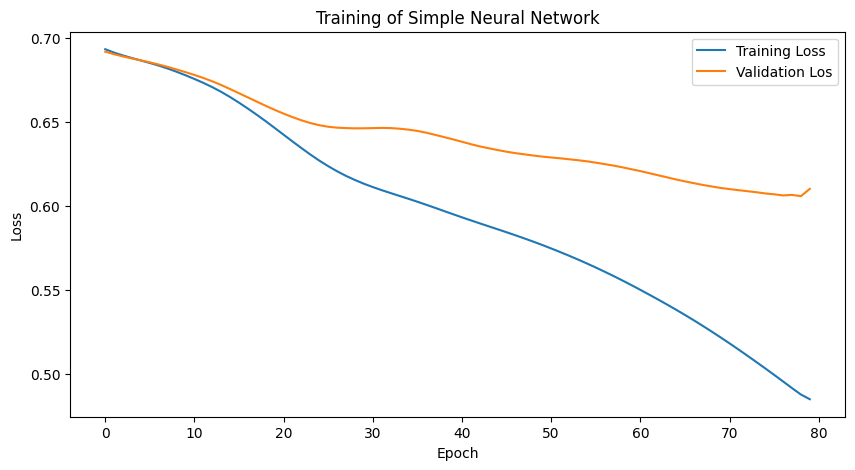

In [14]:
import matplotlib.pyplot as plt

# Converting tensors to lists of scalars
visual_train_losses = [x.item() for x in total_train_losses]
visual_valid_losses = [x.item() for x in total_valid_losses]

# Plotting the values
plt.figure(figsize=(10, 5))
plt.plot(visual_train_losses, label='Training Loss')
plt.plot(visual_valid_losses, label='Validation Los')
plt.title('Training of Simple Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MLP on Test Data

In [15]:
# convert to tensor
for i, X in enumerate(X_test):
    print(f"\n== Testing on data set {i} ==")
    X = torch.tensor(X, dtype=torch.float32)  
    y = torch.tensor(y_test[i], dtype=torch.float32).unsqueeze(1)  # Convert to tensor and ensure correct shape
    result = eval_model(nn_model, X, y, nn_loss_func, verbose=True)


== Testing on data set 0 ==
Accuracy: 0.7500
ROC AUC Score: 0.7405
Precision: 0.8519
Recall: 0.7667
F1 Score: 0.8070
Matthews Correlation Coefficient: 0.4601
Specificity (Negative Prediction Accuracy): 0.7143

== Testing on data set 1 ==
Accuracy: 0.6341
ROC AUC Score: 0.6061
Precision: 0.3750
Recall: 0.5455
F1 Score: 0.4444
Matthews Correlation Coefficient: 0.1927
Specificity (Negative Prediction Accuracy): 0.6667

== Testing on data set 2 ==
Accuracy: 0.7068
ROC AUC Score: 0.6923
Precision: 0.1004
Recall: 0.6765
F1 Score: 0.1749
Matthews Correlation Coefficient: 0.1742
Specificity (Negative Prediction Accuracy): 0.7082
